# Datos de los ligandos

## Obtención de los datos de los ligandos  cocristalizados con CDK2 desde Pubchem y Chembl

**Esta libreta tiene como objetivo extraer datos de las moléculas cocristalizadas con la proteína CDK2 a partir de las bases de datos CheMBL y PubChem**

> Puntos clave de esta libreta:
- Se extrae de la tabla de datos principal de la proteína las conformaciones que poseen a algún ligando en el sitio activo.
- Se crea un set de moléculas usando identificador PDB de cada molécula (cada molécula es designada con un id de 3 letras).
- Se usa el id de cada molécula (LIG) para obtener los datos de la página `http://www.rcsb.org/ligand/LIG`, correspondiente a cada ligando. Con ello obtenemos:
    - El smile isomérico de la molécula.
    - El InChI
    - El InChI Key
- Usamos el **InChI** para obtener los datos de cada molécula desde _**PUBCHEM**_ y _**CHEMBL**_.
- Guardamos los datos en un diccionario y a su vez lo exportamos a un archivo pinckle.

### Importamos algunas librerías iniciales

In [3]:
import pandas as pd
import numpy as np
import glob, os, sys
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')

## Cargamos los datos de la tabla principal

Nombre de la proteína:

In [10]:
# Nombre de la proteina de interes
prot_name = 'cdk2'

Cargamos el dataframe principal de la proteína:

In [13]:
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
patho_to_json_file = glob.glob((os.path.join( 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys_LIGS_INFO.json')))[0]
                      
df_prot_labels = pd.read_json(patho_to_json_file)
df_prot_labels.shape

(402, 14)

**Esta tabla contiene ya la información de la molécula presente en el sitio activo de cada conformación de la proteína**

In [14]:
df_prot_labels.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.0,298,92.953020,2,"[9, 14]","[[36, 44], [149, 162]]",1,[STU],STU,440.0
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.0,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]",ATP,398.0
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.1,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]",ATP,398.0


## Identificación de los inhibidores
### Seleccionamos las conformaciones que posean algun inhibidor

In [15]:
filtro_inh = df_prot_labels.Inhib.notnull()
df_ligs_crys = df_prot_labels[filtro_inh]

In [16]:
# Número total de conformaciones con algún ligando en el sitio activo
df_ligs_crys.shape

(365, 14)

### Identificamos el número de ligandos únicos

In [17]:
ligs_crys_prot = set(df_ligs_crys.Inhib)
len(ligs_crys_prot)

315

## Comenzamos la obtención de los datos
El proceso es el siguiente:
> 1. Con el identificador de la molécula del PDB (nombe de tres letras, por ejemplo: ATP) se busca en el PDB la información de dicha molécula: http://www.rcsb.org/ligand
2. Se obtiene el *chemicalInChIKey*, el *chemicalInChI* y el SMILES isomérico de la molécula.
3. El *InChI el *InChIKey* o en su defecto el SMILES isimérico, es usado para buscar a la molécula en las bases de datos PubChem y Chembl.
    - Dichos *request* a la la API de cada base de datos se hacen con las librerías **_chembl_webresource_client_** y **_pubchemy_**.
4. Todos los datos disponibles de las moléculas son guardados en un diccionario de pyhton.
5. Finalmente el objeto se guarda en un archivo para posteriormente poder tener acceso al mismo.


### Web scrapping de los ligandos

In [8]:
# Librerías útiles para el web scrapping de los ligandos
import urllib.request
from bs4 import BeautifulSoup
from chembl_webresource_client.new_client import new_client
import pubchempy

In [9]:
# Url para accesar a la información de los ligandos en el PDB
URL_PDB = 'http://www.rcsb.org/ligand'

### Obtenemos los datos de cada ligando y los guardamos en un diccionario

In [10]:
# Generamos un diccionario con los datos de la molécula
dic_ligs_crys_prot = {}

for ligando in ligs_crys_prot[:
    url_lig = F'{URL_PDB}/{ligando}'
    print(F'Procesando al ligando: {ligando}\n')
    
    # Extraemos los datos del html del ligando:
    lig_data = urllib.request.urlopen( url_lig ).read().decode()
    
    # Extraemos del bsoup los siguientes datos:
    # InChIKey
    soup = BeautifulSoup(lig_data)
    inchi_key = soup.find("tr", {"id": "chemicalInChIKey"})
    inchi_key_str = inchi_key.find('td').text
    
    # InChI
    inchi = soup.find("tr", {"id": "chemicalInChI"})
    inchi_str = inchi.find('td').text
    
    # isomeric SMILE (por si no se encuentra en la API de PbCh)
    smiles = soup.find("tr", {"id": "chemicalIsomeric"})
    smiles_str = smiles.find('td').text
    
    # Peso molecular
    mw = soup.find("tr", {"id": "chemicalMolecularWeight"})
    mw_str = mw.find('td').text
    
    # Con los datos anteriores usamos la librería para accesar al Chembl
    # **** CHEMBL ****
    # Procedemos a extraer los datos del Chembl
    molecule = new_client.molecule
    try:
        chblMol_info = molecule.get(inchi_key_str)
        chembl_id = chblMol_info['molecule_chembl_id']
    except:
        print(F'No se pudo obtener infor de CEHMBL: {ligando}')
        print(inchi_str + '\n')
        chblMol_info = None
        chembl_id = None
        
    # Ahora obtenemos datos correspondientes a pubchem
    # *** PUBCHEM ***
    try:
        pbch_mol = pubchempy.get_compounds(inchi_str, 'inchi')[0]
        pbch_cid = pbch_mol.cid
        pbch_data = pbch_mol.to_dict()
        canonical_smiles = pbch_mol.canonical_smiles
    except:
        print(F'Fallo con datos PUBCHEM: {ligando}')
        pbch_mol = None
        pbch_cid = None
        pbch_data = None
        canonical_smiles = None
    # Creamos la entrada para el diccionario
    # Primero el diccionario del ligando
    dic_lig = {'inchi_key': inchi_key_str,
               'inchi': inchi_str,
               'molecular_weight': float(mw_str),
               'canonical_smiles': canonical_smiles,
               'isomeric_similes': smiles_str,
               'chembl_id': chembl_id,
               'chembl_data': chblMol_info,
               'pubchem_id': pbch_cid,
               'pubchem_data': pbch_data,}
    
    # Anidamos el dict  del ligando al dic principal
    dic_ligs_crys_prot[ligando] = dic_lig

## Guardamos el set de datos en formato *pickle*

In [6]:
import pickle

In [12]:
nombre_archivo = os.path.join('..','data', 'LIGS_CDK2_crys_pubchem_chembl_data.pkl')
if not os.path.exists(nombre_archivo):
    with open(nombre_archivo, 'wb') as dic_file:
        pickle.dump(dic_ligs_crys_prot, dic_file, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("El archivo ya ha sido creado.")

# Finalmente:
## Uso del diccionario final
A modo de ejemplo visualizamos algunos de los datos disponibles en el diccionario:

In [16]:
import pandas as pd
import numpy as np
import rdkit as rd
import glob, os, sys
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')

### Lectura del diccionario de ligandos cocristalizados

In [18]:
prot_name = 'cdk2'

In [19]:
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
patho_to_json_file = glob.glob((os.path.join('..', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys_LIGS_INFO.json')))[0] 
df_prot_labels = pd.read_json(patho_to_json_file)
filtro_inh = df_prot_labels.Inhib.notnull()
df_ligs_crys = df_prot_labels[filtro_inh]

In [20]:
import pickle
# Lectura del diccionario con pickle
nombre_archivo = os.path.join('..', 'data', 'LIGS_CDK2_crys_pubchem_chembl_data.pkl')
with open(nombre_archivo, 'rb') as dic_file:
    dic_ligs_crys_prot = pickle.load(open(nombre_archivo, 'rb'))

In [21]:
len(dic_ligs_crys_prot)

315

In [22]:
# Generamos el diccionario de moléculas cocristalizadas 
dic_crys_mols = {}
for key in dic_ligs_crys_prot:
    # Usamos el smile isomérico, reportado en el PDB
    smile = dic_ligs_crys_prot[key]['isomeric_similes']
    mol = rd.Chem.MolFromSmiles(smile, False)
    dic_crys_mols[key] = mol

len(dic_crys_mols )

315

ID Chembl: CHEMBL14249
cid Pubchem: 5957
Nombre: ADENOSINE TRIPHOSPHATE


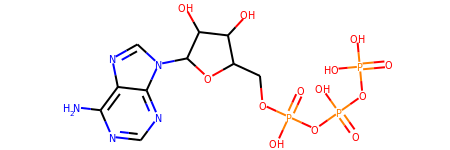

In [11]:
# Obtención del un ligando a través de una conformación
lig_1aq1 = df_ligs_crys.loc['1fin', 'Inhib']
# Imprimimos su nombre y otros datos interesantes
lig_1aq1_data = dic_ligs_crys_prot[lig_1aq1]
print(F'ID Chembl: {lig_1aq1_data["chembl_id"]}')
print(F'cid Pubchem: {lig_1aq1_data["pubchem_id"]}')
print(F'Nombre: {lig_1aq1_data["chembl_data"]["pref_name"]}')
# Obtenemos el smiles canonico
lig_1aq1_smiles = dic_ligs_crys_prot[lig_1aq1]['canonical_smiles']
# Lo visualizamos con rdkit
rd.Chem.MolFromSmiles(lig_1aq1_smiles)

# DUD PRUEBAS

In [27]:
#Convertir el archivo mol2 a sdf para poserlo parsear con rdkit
dud_actives = '../../ARCHIVOS/CRISTALES/LIGS_CDK2/DUDE_DECOYS/DUD_2006/dud_ligands2006/cdk2_ligands'

In [16]:
%%bash -s "$dud_actives"
obabel -imol2 ${1}.mol2 -osmi -O ${1}.smi

72 molecules converted


In [62]:
a = rd.Chem.SDMolSupplier(dud_actives + '.sdf', False)

In [68]:
# Cargade mol2
list_mol2_dud = glob.glob('../../ARCHIVOS/CRISTALES/LIGS_CDK2/DUDE_DECOYS/DUD_2006/\
dud_ligands2006/mol2/*sdf')
# ordenamos la lista
list_mol2_dud = sorted(list_mol2_dud, key = lambda x: int(x.split('_')[-1].split('.')[0]))
# cargamos los ligandos usando rdkit
dic_dud_mol2 = {i.split('/')[-1].split('.')[0]: rd.Chem.SDMolSupplier(i, False)[0] for i in list_mol2_dud}

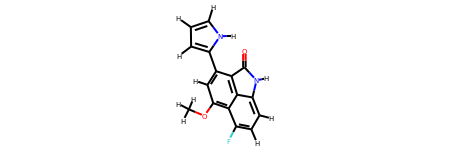

In [76]:
dic_dud_mol2['ligand_1']

In [113]:
contador_lineas = 0
s = [] # Temporalemtne usamos una lista
with open(F'{dud_actives}.smi', "r") as file:
    for i, line in enumerate(file):
        contador_lineas += 1
        s.append(line)
contador_lineas
len(s)

72

In [ ]:
#Convertir el archivo mol2 a sdf para poserlo parsear con rdkit
dud_decoys_smi = '../../ARCHIVOS/CRISTALES/LIGS_CDK2/DUDE_DECOYS/DUD_2006/dud_decoys2006/'

In [ ]:
contador_lineas = 0
s = [] # Temporalemtne usamos una lista
with open(F'{dud_actives}.smi', "r") as file:
    for i, line in enumerate(file):
        contador_lineas += 1
        s.append(line)
contador_lineas
len(s)

In [139]:
# Creamos una tabla pivote para enlzar el zinc id con elnombre del archivo mol2 usado para eldocking
list_mol2_dud_files = glob.glob('../../ARCHIVOS/CRISTALES/LIGS_CDK2/DUDE_DECOYS/DUD_2006/\
dud_ligands2006/mol2/*mol2')

dic_dus_zincid_file = {}
# Crea el diccionario necesario
for i in list_mol2_dud_files:
    file_name = i.split('/')[-1].split('.')[0]
    with open(i, 'r') as f:
        first_line = f.readlines()[1].replace('\n', '')
        dic_dus_zincid_file[first_line] = file_name
        

In [167]:
# dic_dus_zincid_file

In [110]:
# Extremos del set los smiles
dic_dud_mols = {}
# ordenamos el set
set_ordenado = sorted(s, key = lambda x: int(x.replace('\n', '').split('ZINC')[1]))
for i, string in enumerate(set_ordenado):
    split_string = string.replace('\n', '').split('\t')
    mol_name = F'{i}_{split_string[1]}'
    mol_smile = split_string[0]
    mol_rdkit = rd.Chem.MolFromSmiles(mol_smile, False)
    dic_dud_mols[mol_name] = mol_rdkit

In [111]:
len(dic_dud_mols)

58

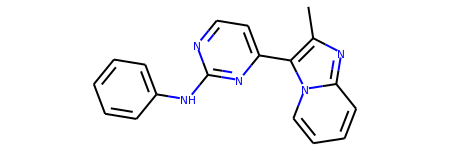

In [23]:
dic_dud_mols['26_ZINC03814452']

In [109]:
# Un set para ver si hay repetidos en los smiles
set_smiles = set()
for i in dic_dud_mols:
    set_smiles.add(i)
    
len(set_smiles) == len(dic_dud_mols)

True

In [25]:
# Extraemos los smiles de los activos de DUD
dud_smiles_iso = []
for key,smi in dic_dud_mols.items():
    smi = rd.Chem.MolToSmiles(smi, isomericSmiles=True)
    dud_smiles_iso.append( smi )

#dud_smiles_iso

In [24]:
# Generamos el diccionario de moléculas cocristalizadas 
dic_crys_mols = {}
for key in dic_ligs_crys_prot:
    # Usamos el smile isomérico, pues no de todos los ligandos fue posible obtener el canónico
    # Debido a que el API de Chembl no está actualizada (moleculas depositadas en 2019 suelen dar error)
    # Aunque rdkit, puede proveerlo una vez cargada la molécula
    smile = dic_ligs_crys_prot[key]['isomeric_similes']
    mol = rd.Chem.MolFromSmiles(smile, False)
    dic_crys_mols[key] = mol

len(dic_crys_mols )

317

In [25]:
# Extraemos los smiles canónicos de las moléculas cocristalizadas
crys_smiles_iso = []
for key,smi in dic_crys_mols.items():
    smi = rd.Chem.MolToSmiles(smi, isomericSmiles=True )
    crys_smiles_iso.append( smi)

#crys_smiles_iso

In [80]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

In [140]:
dic_fps_dud = {i: rd.Chem.RDKFingerprint(j) for i, j in dic_dud_mols.items()}
dic_fps_crys = {i: rd.Chem.RDKFingerprint(j) for i, j in dic_crys_mols.items()}

In [142]:
dic_fps_crys['CK2']

In [170]:
contador_sim = 0
cutoff = 0.97

lista_Archivos = []
# Comparamos similitud entre los ligandos
for name_crys, fps_crys in dic_fps_crys.items():
    for name_dud, fps_dud in dic_fps_dud.items():
        # Comparamos ambas estructuras usando los fingerprints
        similarity = DataStructs.FingerprintSimilarity(fps_dud, fps_crys,
                    metric= DataStructs.TanimotoSimilarity)
        if similarity >= cutoff:
            contador_sim += 1
            print(contador_sim, name_dud, name_crys, similarity)
            # Me dice el nombre del archivo
            lista_Archivos.append(dic_dus_zincid_file[name_dud.split('_')[-1]])
            break # Termina el ciclo si encuentra al menos una estructura

1 14_ZINC03814435 UCN 1.0
2 9_ZINC01641925 OLO 1.0
3 51_ZINC03814479 NW1 1.0
4 11_ZINC03591113 I17 1.0
5 20_ZINC03814444 LS2 1.0
6 41_ZINC03814467 SU9 1.0
7 36_ZINC03814462 2A6 1.0
8 19_ZINC03814443 LS1 1.0
9 21_ZINC03814447 LS4 1.0
10 15_ZINC03814437 PVB 1.0
11 34_ZINC03814460 UN4 1.0
12 24_ZINC03814451 ST8 1.0
13 35_ZINC03814461 6CP 1.0
14 7_ZINC00603011 4SP 1.0
15 1_ZINC00023543 CMG 1.0
16 17_ZINC03814440 INR 1.0
17 31_ZINC03814457 MBP 1.0
18 10_ZINC01649340 RRC 1.0
19 56_ZINC04617747 LS5 1.0
20 13_ZINC03814434 STU 1.0
21 22_ZINC03814449 1PU 1.0


In [171]:
            
lista_Archivos

['ligand_16',
 'ligand_11',
 'ligand_66',
 'ligand_13',
 'ligand_22',
 'ligand_52',
 'ligand_45',
 'ligand_21',
 'ligand_23',
 'ligand_17',
 'ligand_40',
 'ligand_27',
 'ligand_43',
 'ligand_9',
 'ligand_2',
 'ligand_19',
 'ligand_34',
 'ligand_12',
 'ligand_71',
 'ligand_15',
 'ligand_24']

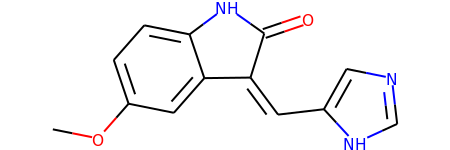

In [156]:
dic_dud_mols['41_ZINC03814467']

RDKit ERROR: [08:18:17] Can't kekulize mol.  Unkekulized atoms: 10 11 13
RDKit ERROR: 


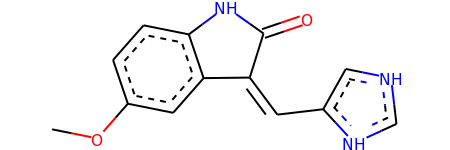

In [158]:
dic_dud_mols['42_ZINC03814467']

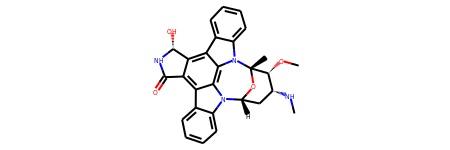

In [153]:
dic_crys_mols['UCN']

In [ ]:
# Otra comparación esntre estructura a 0.9

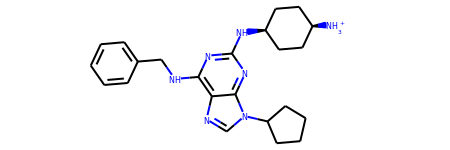

In [164]:
dic_dud_mols['11_ZINC03591113']

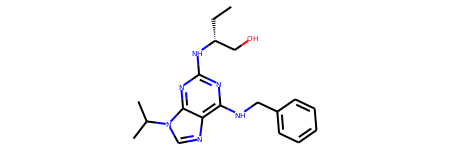

In [165]:
dic_crys_mols['RRC']

## Comparación con los ligandos cocristalizados

In [29]:
# Cargamos la tabla de información de los ligandos CSAR
df_csar_2012 = pd.read_json('./data/csar_Binding_Data_Corrected_2016.json')

In [30]:
# Cargamos las moléculas en un diccionario usando rdkit
dic_csar_mols = {i: rd.Chem.MolFromSmiles(df_csar_2012.loc[i, "SMILES"]) for i in df_csar_2012.index}

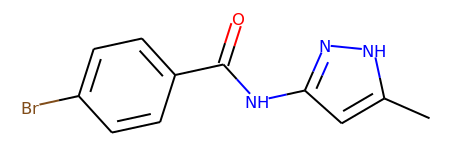

In [31]:
# Ejemplo de una primer molécula
dic_csar_mols['CS1']

In [36]:
# Ahora calculamos los fingerprints
dic_fps_csar = {i: rd.Chem.RDKFingerprint(j) for i, j in dic_csar_mols.items()}
dic_fps_crys = {i: rd.Chem.RDKFingerprint(j) for i, j in dic_crys_mols.items()}

In [33]:
# Comparamos los fingerprints de CSAR frente a los cristalográficos

In [71]:
contador_sim = 0
cutoff = 1
# Comparamos similitud entre los ligandos
for name_csar, fps_csar in dic_fps_csar.items():
    for name_crys, fps_crys in dic_fps_crys.items():
        # Comparamos ambas estructuras usando los fingerprints
        similarity = DataStructs.FingerprintSimilarity(fps_csar, fps_crys)
        if similarity >= cutoff:
            contador_sim += 1
            print(contador_sim, name_csar, name_crys)
            break

1 CS1 1CK
2 CS3 03K
3 CS4 4CK
4 CS9 09K
5 CS11 11K
6 CS12 CK2
7 CS16 16K
8 CS18 18K
9 CS19 19K
10 CS20 20K
11 CS241 LS5
12 CS242 42K
13 CS245 45K
14 CS248 48K
15 CS260 60K
16 CS261 61K
17 CS262 62K


In [72]:
df_csar_2012[df_csar_2012.ActiveInactive == 'Active'][df_csar_2012['PDB ID'].notnull()]['PDB ID']
# De arriba faltan CS10, CS146, 

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


CS1      4EK4
CS3      4EK5
CS4      4FKG
CS9      4FKI
CS10     4EK6
CS11     4FJK
CS12     4FKL
CS16     4EK8
CS18     3SW4
CS19     3SW7
CS20     4FKO
CS241    4FKP
CS242    4FKQ
CS245    4FKR
CS246    4FKS
CS248    4FKT
CS260    4FKU
CS261    4FKV
CS262    4FKW
Name: PDB ID, dtype: object

In [70]:
# Ligandos que en CSAR no tienen cristal
df_csar_2012[df_csar_2012.ActiveInactive == 'Active'][df_csar_2012['PDB ID'].isnull()]['PDB ID']

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


CS2      None
CS13     None
CS14     None
CS15     None
CS17     None
CS244    None
CS247    None
Name: PDB ID, dtype: object

In [103]:
contador_sim = 0
cutoff = 0.8
# Comparamos similitud entre los ligandos
for name_csar, fps_csar in dic_fps_csar.items():
    for name_crys, fps_crys in dic_fps_crys.items():
        # Comparamos ambas estructuras usando los fingerprints
        similarity = DataStructs.FingerprintSimilarity(fps_csar, fps_crys)
        if similarity >= cutoff:
            contador_sim += 1
            print(contador_sim, name_csar, name_crys)
            break

1 CS1 1CK
2 CS3 4CK
3 CS4 4CK
4 CS9 09K
5 CS11 09K
6 CS12 CK8
7 CS13 CK8
8 CS14 CK8
9 CS15 CK8
10 CS16 19K
11 CS17 CK7
12 CS18 CK8
13 CS19 19K
14 CS20 CK8
15 CS241 48K
16 CS242 42K
17 CS244 45K
18 CS245 45K
19 CS246 45K
20 CS247 61K
21 CS248 48K
22 CS260 62K
23 CS261 61K
24 CS262 62K


In [ ]:
CS13 CK5
CS14 CK8
CS17 CK7
CS244 46K
CS247 61K

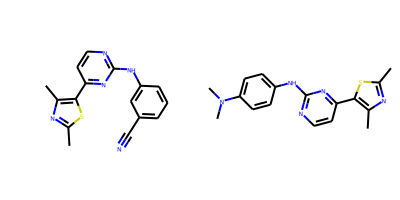

In [104]:
from rdkit.Chem import Draw
ls = [dic_csar_mols['CS15'], dic_crys_mols['CK8']]

img = Draw.MolsToGridImage( ls, molsPerRow=2, useSVG=True )
img

In [102]:


# df_prot_labels.loc['4EK6'] # 4ek6 fue removida durante el modelado con 
# modeller ya que modelar el loop no fue posible

In [45]:
df_csar_2012[df_csar_2012.ActiveInactive == 'Active']['PDB ID'].count()

19

In [106]:
# No están ni 4e6k (CS10) ni 4fks (cs246)

In [ ]:
# ¿Por que 4fks no está? Las compararemos a continuación

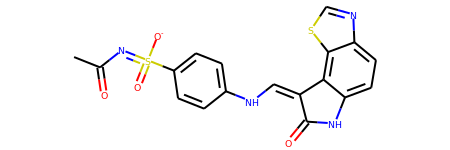

In [108]:
dic_csar_mols['CS246']

In [111]:
df_prot_labels.loc['4fks', 'Inhib']

'46K'

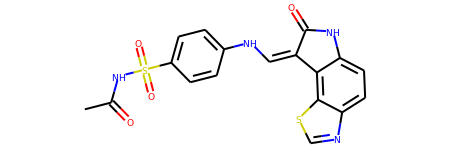

In [112]:
# LA conformación reportada por el pdb es esta:
dic_crys_mols['46K']

In [160]:
DataStructs.FingerprintSimilarity(dic_fps_csar['CS246'], dic_fps_crys['46K'], 
                                  metric = DataStructs.DiceSimilarity)

0.9312859884836853